# Imports

In [5]:
from __future__ import division, print_function, absolute_import, unicode_literals
from IPython.core.debugger import set_trace

import networkx as nx
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from time import time
from typing import Text
import tensorflow as tf

import sys
sys.path.insert(0, '../src/')
import utils
import text_processor
import broadcast_network_extraction

In [6]:
net_extractor = broadcast_network_extraction.NetworkExtraction()
content_fixer = text_processor.FormalEnglishTranslator('../bagofwords/slang.txt')

In [7]:
directory = '/Users/koasato/Documents/koa/College/UCSB/2019-2020/Research/Jeopardy/'
data = None
try:
    data = utils.load_it(directory + 'Teams_logs.pk')
except:
    print("ERROR")

print(len(data))

49


In [8]:
combined_logs = {}
for team_id, team_log in data.items():
    print("Processing team", team_id, '...')
    this_team_nets = []
    this_team_number_of_networks = min(
        len(team_log.messages) // 5,
        len(team_log.member_influences))
    all_messages_before_appraisal_reports = []
    for i in range(this_team_number_of_networks):
        all_messages_before_appraisal_reports.append(
            pd.concat(
                [team_log.messages[i] for i in np.arange(i * 5, i * 5 + 5)]))
    if len(all_messages_before_appraisal_reports) > 0:
        combined_logs[team_id] = all_messages_before_appraisal_reports
    else:
        print('Team', team_id, 'does not have enough logs.')

Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 35 ...
Team 35 does not have enough logs.
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 72 ...
Team 72 does not have enough logs.
Processing team 73 ...
Team 73 doe

In [42]:
total_mse = np.zeros(shape=(16,16))
for b in range(0, 16):
    for e in range(0, 16):
        if b >= e:
            continue
        time_window = [b, e]
        cumulative_mse_for_time_window = 0
        counter = 0
        
        print("time window = ", time_window)
        for team_id, all_messages_before_appraisal_reports in combined_logs.items():
            members = data[team_id].members
            print("Processing team", team_id, '...')
            this_team_nets = []
            
            for index, all_messages_before_appraisal_report in enumerate(all_messages_before_appraisal_reports):
                reply_duration_net = net_extractor.extract_network_from_broadcast(            
                    communication_data=all_messages_before_appraisal_report,
                    time_window=time_window,
                    weight_type=broadcast_network_extraction.WeightType.REPLY_DURATION,
                    aggregation_type=broadcast_network_extraction.AggregationType.SUM,
                    gamma=0.15,
                    node_list=members)
                influence_matrix = np.matrix(data[team_id].member_influences[index])
                to_be_predicted_influence_matrix = utils.shuffle_matrix_in_given_order(
                        matrix=influence_matrix,
                        order=np.argsort(members)) / 100
                # Use reply_duration_net to predict to_be_predicted_influence_matrix
                reply_duration_net_matrix = nx.adj_matrix(reply_duration_net).todense()
                
                # DEBUG PRINTS
                mse = (np.square(reply_duration_net_matrix - to_be_predicted_influence_matrix)).mean(axis=None)
                #print(mse)
#                 set_trace()
                counter = counter + 1
                cumulative_mse_for_time_window += mse
        print(cumulative_mse_for_time_window / counter)
        total_mse[b][e] = cumulative_mse_for_time_window / counter
                

time window =  [0, 1]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing te

Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
3.515306745927953
time window =  [0, 9]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32

4.892683964409255
time window =  [1, 2]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82

Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
2.6845662847378318
time window =  [1, 10]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 

Processing team 87 ...
Processing team 88 ...
0.34724832353790164
time window =  [2, 4]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 

Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
2.141421047879908
time window =  [2, 12]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 2

Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.6694193938647567
time window =  [3, 7]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 7

Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
1.7484416106581655
time window =  [3, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 

Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.855889595333424
time window =  [4, 11]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 7

Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.33509484380198806
time window =  [5, 9]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 

Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.7925223784134193
time window =  [6, 7]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 4

Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.46897170717883524
time window =  [6, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team

Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.2746044684721413
time window =  [7, 14]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 

Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.19184216608701285
time window =  [8, 15]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team

Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.14402184000125573
time window =  [10, 11]
Processing team 7 ...
Processing team 10 ...
Processing team 11 ...
Processing team 12 ...
Processing team 13 ...
Processing team 14 ...
Processing team 15 ...
Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing tea

Processing team 16 ...
Processing team 17 ...
Processing team 19 ...
Processing team 20 ...
Processing team 21 ...
Processing team 22 ...
Processing team 23 ...
Processing team 27 ...
Processing team 28 ...
Processing team 30 ...
Processing team 31 ...
Processing team 32 ...
Processing team 33 ...
Processing team 34 ...
Processing team 36 ...
Processing team 37 ...
Processing team 38 ...
Processing team 39 ...
Processing team 40 ...
Processing team 41 ...
Processing team 42 ...
Processing team 43 ...
Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.07462394838000426
time window =  [11, 15]
Processing team 7 ...
Processing team 10 ...
Processing tea

Processing team 44 ...
Processing team 45 ...
Processing team 46 ...
Processing team 47 ...
Processing team 48 ...
Processing team 49 ...
Processing team 70 ...
Processing team 71 ...
Processing team 74 ...
Processing team 75 ...
Processing team 77 ...
Processing team 79 ...
Processing team 82 ...
Processing team 84 ...
Processing team 85 ...
Processing team 87 ...
Processing team 88 ...
0.06760313528369025


In [43]:
print(total_mse)

[[0.         0.55142177 0.89883834 1.34337971 1.8685782  2.35625288
  2.77934687 3.18578218 3.51530675 3.8218011  4.08270028 4.29732907
  4.48369829 4.65079329 4.78022729 4.89268396]
 [0.         0.         0.42241389 0.72812451 1.11388088 1.49152358
  1.82609517 2.15309358 2.42653524 2.68456628 2.90168362 3.08325931
  3.24032109 3.38245479 3.49167622 3.58626663]
 [0.         0.         0.         0.34724832 0.60334918 0.87844464
  1.13396873 1.38913187 1.60468679 1.81355637 1.99185056 2.14142105
  2.27251886 2.39039748 2.48093165 2.5610866 ]
 [0.         0.         0.         0.         0.29499467 0.48338448
  0.66941939 0.86506112 1.03344091 1.20006805 1.34298484 1.46442771
  1.5726785  1.67140072 1.74844161 1.81628769]
 [0.         0.         0.         0.         0.         0.23529252
  0.35603658 0.4951509  0.61907996 0.74468895 0.8558896  0.95153304
  1.03835995 1.11719556 1.17900241 1.2345092 ]
 [0.         0.         0.         0.         0.         0.
  0.17083494 0.25310363 0

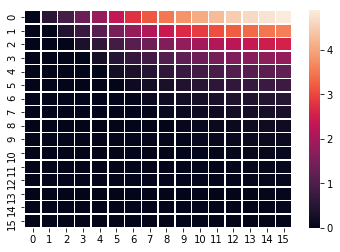

In [44]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(total_mse, linewidth=0.5)
plt.show()